# Generation of hyperspectral samples using Wasserstein-GANs

Wasserstein-GANs are Generative Adversarial Models that can be used to generate synthetic data that approximates a specific input distribution of real data.

In this notebook, we show how to use such a tool to generate *ex nihilo* synthetic hyperspectral samples.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.utils.data
from scipy.io import loadmat
from skimage import io
import spectral

We load the Pavia University dataset. The `.mat` files are available on [this website](http://www.ehu.eus/ccwintco/index.php?title=Hyperspectral_Remote_Sensing_Scenes).

In [2]:
img = loadmat('/user_data/HyperX/PaviaU.mat')['paviaU']
gt = loadmat('/user_data/HyperX/PaviaU_gt.mat')['paviaU_gt']

The ground truth is shown below. We sample 10% from the pixels as training samples.

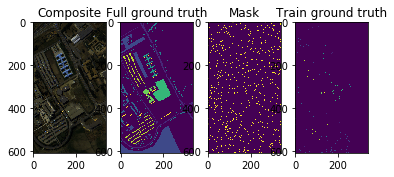

In [3]:
mask = np.random.randint(0, 100, gt.shape) < 5
train_gt = np.copy(gt)
train_gt[np.nonzero(~mask)] = 0
test_gt = np.copy(gt)
test_gt[train_gt > 0] = 0

rgb = img[:,:,(55,41,12)]
rgb = (255 * (rgb.astype(np.float32) - rgb.min())/(rgb.max() - rgb.min())).astype(np.uint8)
fig = plt.figure()
fig.add_subplot(141)
plt.imshow(rgb)
plt.title("Composite")
fig.add_subplot(142)
plt.imshow(gt)
plt.title("Full ground truth")
fig.add_subplot(143)
plt.imshow(mask)
plt.title("Mask")
fig.add_subplot(144)
plt.imshow(train_gt)
plt.title("Train ground truth")
plt.show()

We define a `HyperX` class to hold the dataset. Note that the label is encoded as a one-hot vector.

In [4]:
from skimage import morphology

class HyperX(torch.utils.data.Dataset):
    
    def __init__(self, data, ground_truth, semi=False):
        super(HyperX, self).__init__()
        # Normalize the data in [0,1]
        data = (data - data.min()) / (data.max() - data.min())
        self.data = data
        self.gt = ground_truth
        self.n_classes = len(np.unique(ground_truth))
        if semi:
            # Semi-supervision, include neighbours at 50px
            x_pos, y_pos = np.nonzero(morphology.dilation(ground_truth > 0, morphology.disk(50)))
        else:
            x_pos, y_pos = np.nonzero(ground_truth)
        self.indices = [idx for idx in zip(x_pos, y_pos)]
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, i):
        x, y = self.indices[i]
        data = self.data[x,y]
        # Get the label in one-hot encoded style
        label = np.asarray(np.eye(self.n_classes)[self.gt[x, y]], dtype='int64')
        return torch.from_numpy(data), torch.from_numpy(label)

In [5]:
import os
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

# Basic generator that maps: noise + condition -> fake samples
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # LeakyReLU is preferred to keep gradients flowing even for negative activations
        self.generator = torch.nn.Sequential(
            torch.nn.Linear(z_dim + c_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, X_dim),
            torch.nn.Sigmoid() # smooth [0,1] outputs
        )
        self.apply(weight_init)

    def forward(self, z, c):
        # Concatenate the noise and condition
        inputs = torch.cat([z, c], 1)
        return self.generator(inputs)

# Basic fully connected discriminator: sample -> -infty -- fake - 0 - real -- +infty
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = torch.nn.Sequential(
            torch.nn.Linear(X_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, 1)
        )
        
        self.apply(weight_init)

    def forward(self, X):
        return self.discriminator(X)

# Basic fully connected classifier: sample -> class
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.discriminator = torch.nn.Sequential(
            torch.nn.Linear(X_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, c_dim)
        )
        
        self.apply(weight_init)

    def forward(self, X):
        return self.discriminator(X)

In [6]:
mb_size = 256 # Batch size
z_dim = 30   # Noise dimension
X_dim = img.shape[-1] # Number of bands
h_dim = 512  # Hidden layer size
d_step = 5   # Number of discriminator training steps for each generator training step
lr = 5e-5    # Learning rate
c_weight = 0.2 # Auxiliary classifier weight
flip_percentage = 0.0 # Proportion of label flipping
mixup_alpha = 0.1 # Mixup
semi_supervised = True # semi-supervision (set to True to include unlabeled samples)

# Build the dataset and data loader
data_loader = torch.utils.data.DataLoader(
    HyperX(img, train_gt if semi_supervised else gt), batch_size=mb_size, shuffle=True)
# c_dim = condition vector size
c_dim = data_loader.dataset.n_classes

# Ignore the class 0
class_weights = torch.ones((c_dim))
class_weights[0] = 0.
class_weights = class_weights.cuda()

In [7]:
# Initialize weights using the He et al. (2015) policy.
def weight_init(m):
    if isinstance(m, (nn.Linear, nn.Conv2d, nn.Conv3d, nn.ConvTranspose3d)):
        torch.nn.init.kaiming_normal_(m.weight.data)

# Spherical interpolation between two vectors on the unit hypersphere
# See : https://github.com/soumith/dcgan.torch/issues/14
def slerp(val, low, high):
    omega = np.arccos(np.clip(np.dot(low/np.linalg.norm(low), high/np.linalg.norm(high)), -1, 1))
    so = np.sin(omega)
    if so == 0:
        return (1.0-val) * low + val * high # L'Hopital's rule/LERP
    return np.sin((1.0-val)*omega) / so * low + np.sin(val*omega) / so * high

def lerp(val, low, high):
    return (1.0-val) * low + val * high # L'Hopital's rule/LERP

# Gradient penalty from the Improved WGAN training
# From : https://github.com/EmilienDupont/wgan-gp
# Use penalty_weight set at 10, as suggested in the paper
def calc_gradient_penalty(netD, real_data, generated_data, penalty_weight=10):
        batch_size = real_data.size()[0]

        alpha = torch.rand(batch_size, 1) if real_data.dim() == 2 else torch.rand(batch_size, 1, 1, 1)
        alpha = alpha.expand_as(real_data)
        alpha = alpha.cuda()
        
        interpolated = alpha * real_data + (1 - alpha) * generated_data
        #interpolated = Variable(interpolated, requires_grad=True)
        interpolated.requires_grad_()
        interpolated = interpolated.cuda()

        # Calculate probability of interpolated examples
        prob_interpolated = netD(interpolated)

        # Calculate gradients of probabilities with respect to examples
        gradients = torch.autograd.grad(outputs=prob_interpolated, inputs=interpolated,
                               grad_outputs=torch.ones(prob_interpolated.size()).cuda(),
                               create_graph=True, retain_graph=True)[0]

        # Gradients have shape (batch_size, num_channels, img_width, img_height),
        # so flatten to easily take norm per example in batch
        gradients = gradients.view(batch_size, -1)

        # Derivatives of the gradient close to 0 can cause problems because of
        # the square root, so manually calculate norm and add epsilon
        gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

        # Return gradient penalty
        return penalty_weight * ((gradients_norm - 1) ** 2).mean()
    
def reset_grad(*nets):
    for net in nets:
        net.zero_grad()
        
def plot_mean_std(samples):
    mean_spectrum = np.mean(samples, axis=0)
    std_spectrum = np.std(samples, axis=0)
    plt.plot(mean_spectrum - std_spectrum, linestyle='dotted', label='-std')
    plt.plot(mean_spectrum, label='mean')
    plt.plot(mean_spectrum + std_spectrum, linestyle='dotted', label='+std')

  0%|          | 0/100000 [00:00<?, ?it/s]/home/naudeber/.venvs/timeless/lib/python3.5/site-packages/ipykernel_launcher.py:64: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Iter-0; D_loss: -1.5734221935272217; G_loss: 2.7932257652282715; C_loss: 1.7224024534225464


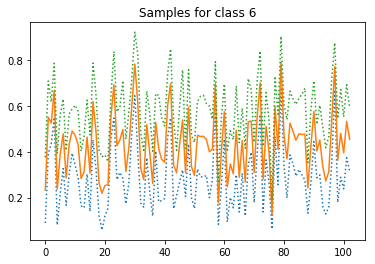

  1%|          | 999/100000 [01:29<2:28:29, 11.11it/s]

Iter-1000; D_loss: -0.2837206721305847; G_loss: -0.3255658745765686; C_loss: 0.2637670040130615


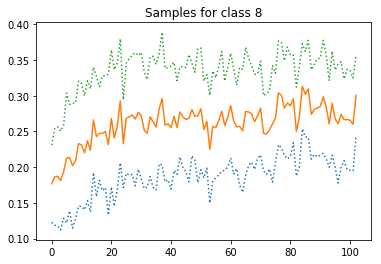

  2%|▏         | 1999/100000 [02:59<2:26:50, 11.12it/s]

Iter-2000; D_loss: -0.09918103367090225; G_loss: -0.09214560687541962; C_loss: 0.08337822556495667


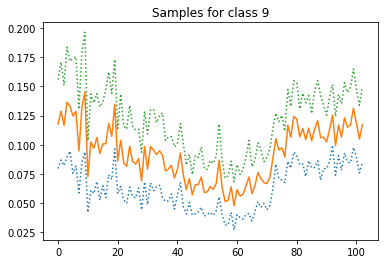

  3%|▎         | 2999/100000 [04:29<2:25:22, 11.12it/s]

Iter-3000; D_loss: -0.06954117119312286; G_loss: -0.2949066162109375; C_loss: 0.027611540630459785


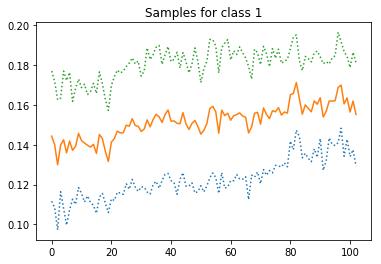

  4%|▍         | 3999/100000 [06:00<2:24:08, 11.10it/s]

Iter-4000; D_loss: -0.04946090281009674; G_loss: -0.19449788331985474; C_loss: 0.028838440775871277


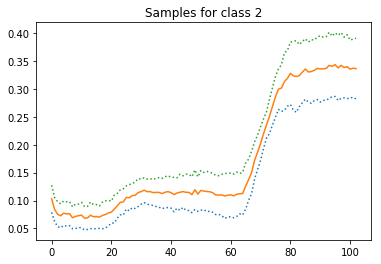

  5%|▌         | 5000/100000 [07:32<2:23:14, 11.05it/s]

Iter-5000; D_loss: -0.041549552232027054; G_loss: -0.10911549627780914; C_loss: 0.027932530269026756


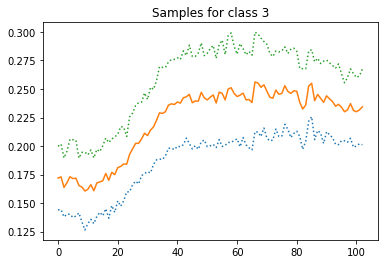

  6%|▌         | 5999/100000 [09:03<2:21:59, 11.03it/s]

Iter-6000; D_loss: -0.035281650722026825; G_loss: -0.0032018052879720926; C_loss: 0.01807752437889576


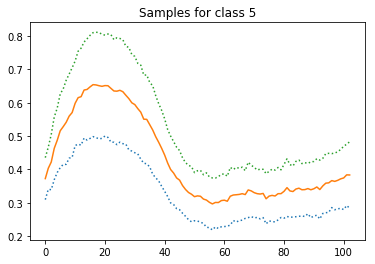

  7%|▋         | 7000/100000 [10:37<2:21:13, 10.98it/s]

Iter-7000; D_loss: -0.02340453490614891; G_loss: -0.0018868608167394996; C_loss: 0.028400922194123268


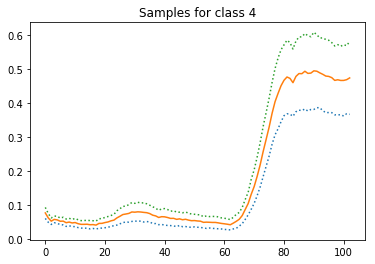

  8%|▊         | 8000/100000 [12:15<2:20:57, 10.88it/s]

Iter-8000; D_loss: -0.016007982194423676; G_loss: -0.005139944143593311; C_loss: 0.012460103258490562


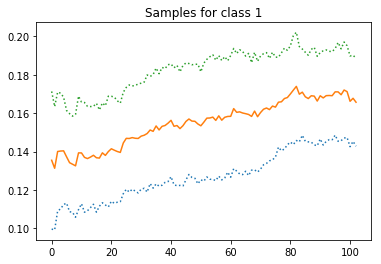

  9%|▉         | 9000/100000 [13:50<2:19:59, 10.83it/s]

Iter-9000; D_loss: -0.03212549537420273; G_loss: 0.011555243283510208; C_loss: 0.010083099827170372


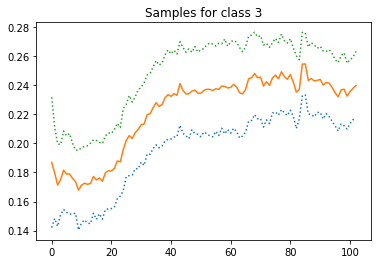

 10%|█         | 10000/100000 [15:23<2:18:30, 10.83it/s]

Iter-10000; D_loss: -0.009619871154427528; G_loss: 0.0017376297619193792; C_loss: 0.011130770668387413


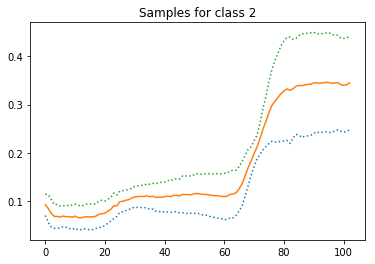

 11%|█         | 10999/100000 [16:55<2:17:00, 10.83it/s]

Iter-11000; D_loss: -0.0238503348082304; G_loss: 0.022087134420871735; C_loss: 0.017036546021699905


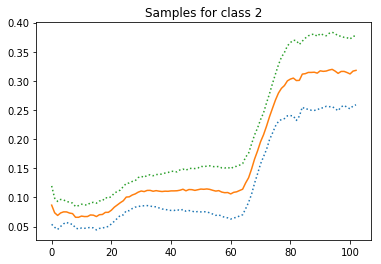

 12%|█▏        | 11999/100000 [18:28<2:15:26, 10.83it/s]

Iter-12000; D_loss: -0.0031770458444952965; G_loss: 0.015095967799425125; C_loss: 0.020324211567640305


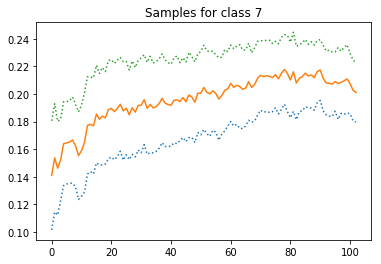

 13%|█▎        | 12999/100000 [20:00<2:13:56, 10.83it/s]

Iter-13000; D_loss: -0.0241384319961071; G_loss: -0.03191870450973511; C_loss: 0.02681838721036911


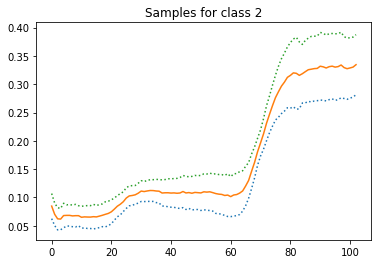

 14%|█▍        | 13999/100000 [21:33<2:12:23, 10.83it/s]

Iter-14000; D_loss: -0.006676197983324528; G_loss: -0.04270308092236519; C_loss: 0.016633860766887665


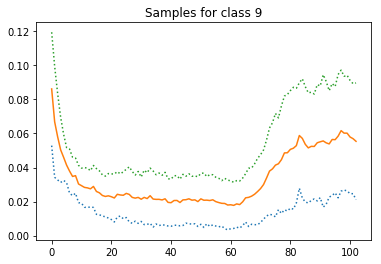

 15%|█▍        | 14999/100000 [23:05<2:10:52, 10.82it/s]

Iter-15000; D_loss: -0.009966900572180748; G_loss: -0.03554157540202141; C_loss: 0.031371526420116425


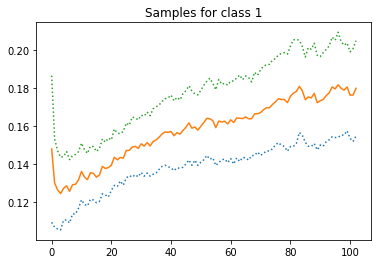

 16%|█▌        | 15999/100000 [24:38<2:09:21, 10.82it/s]

Iter-16000; D_loss: -0.009458618238568306; G_loss: -0.06272845715284348; C_loss: 0.010022339411079884


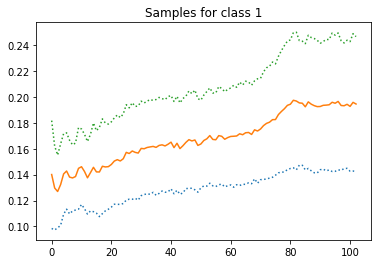

 17%|█▋        | 17000/100000 [26:10<2:07:48, 10.82it/s]

Iter-17000; D_loss: -0.01871604472398758; G_loss: -0.047167640179395676; C_loss: 0.0305657759308815


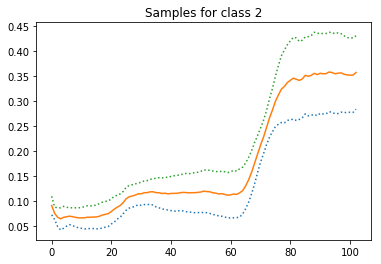

 18%|█▊        | 17999/100000 [27:43<2:06:19, 10.82it/s]

Iter-18000; D_loss: -0.00851170439273119; G_loss: -0.07644068449735641; C_loss: 0.023114141076803207


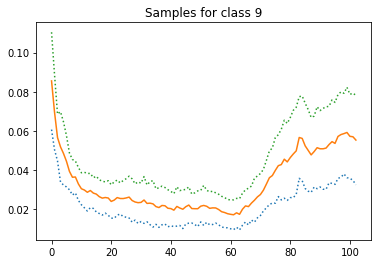

 19%|█▉        | 19000/100000 [29:16<2:04:46, 10.82it/s]

Iter-19000; D_loss: -0.01361947413533926; G_loss: -0.022155210375785828; C_loss: 0.015274110250175


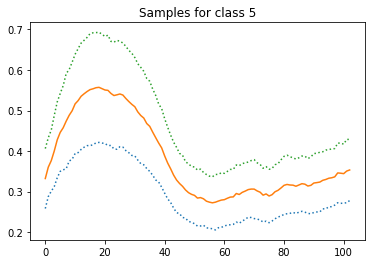

 20%|█▉        | 19999/100000 [30:48<2:03:15, 10.82it/s]

Iter-20000; D_loss: 0.005178745836019516; G_loss: -0.05064476281404495; C_loss: 0.017481453716754913


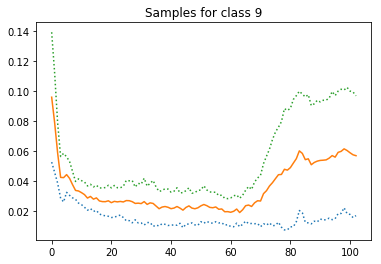

 21%|██        | 20999/100000 [32:21<2:01:43, 10.82it/s]

Iter-21000; D_loss: -0.027546225115656853; G_loss: -0.04982467740774155; C_loss: 0.029350023716688156


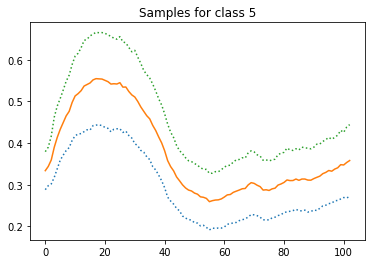

 22%|██▏       | 22000/100000 [33:54<2:00:11, 10.82it/s]

Iter-22000; D_loss: -0.0068311505019664764; G_loss: -0.056035883724689484; C_loss: 0.024303967133164406


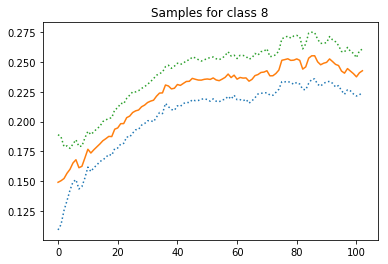

 23%|██▎       | 23000/100000 [35:26<1:58:39, 10.82it/s]

Iter-23000; D_loss: -0.006251584272831678; G_loss: -0.043337780982255936; C_loss: 0.012732349336147308


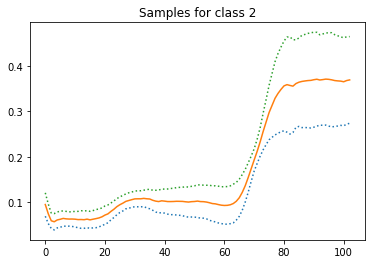

 24%|██▍       | 23999/100000 [36:59<1:57:07, 10.81it/s]

Iter-24000; D_loss: -0.008114264346659184; G_loss: -0.055340249091386795; C_loss: 0.008526739664375782


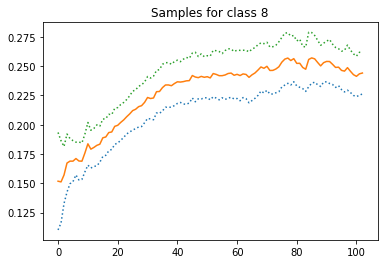

 25%|██▍       | 24999/100000 [38:31<1:55:35, 10.81it/s]

Iter-25000; D_loss: -0.011793403886258602; G_loss: -0.04086853563785553; C_loss: 0.01212749257683754


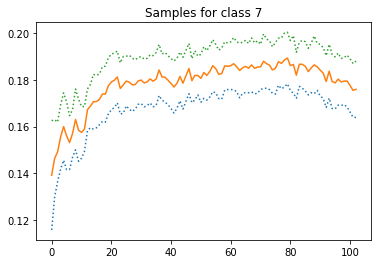

 26%|██▌       | 26000/100000 [40:04<1:54:04, 10.81it/s]

Iter-26000; D_loss: -0.014204640872776508; G_loss: -0.03846973180770874; C_loss: 0.012530572712421417


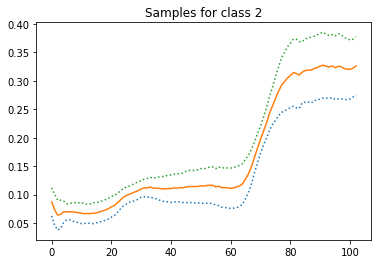

 27%|██▋       | 26999/100000 [41:38<1:52:35, 10.81it/s]

Iter-27000; D_loss: -0.010606438852846622; G_loss: -0.043103449046611786; C_loss: 0.013295640237629414


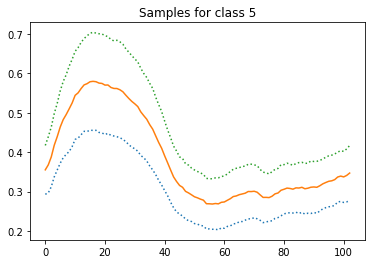

 28%|██▊       | 27999/100000 [43:11<1:51:03, 10.81it/s]

Iter-28000; D_loss: -0.009972602128982544; G_loss: -0.07275724411010742; C_loss: 0.007598431780934334


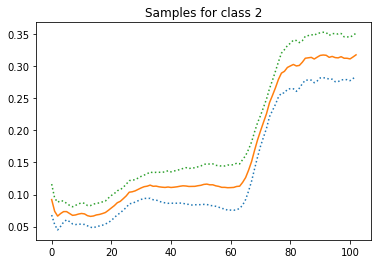

 29%|██▉       | 28999/100000 [44:43<1:49:30, 10.81it/s]

Iter-29000; D_loss: -0.016933031380176544; G_loss: -0.04961363226175308; C_loss: 0.012369414791464806


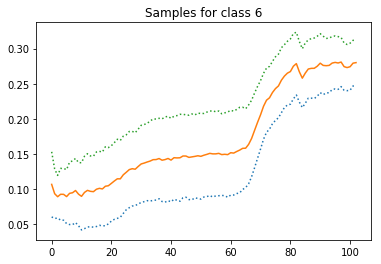

 30%|██▉       | 29999/100000 [46:15<1:47:56, 10.81it/s]

Iter-30000; D_loss: -0.0007920395582914352; G_loss: -0.06242572143673897; C_loss: 0.015789901837706566


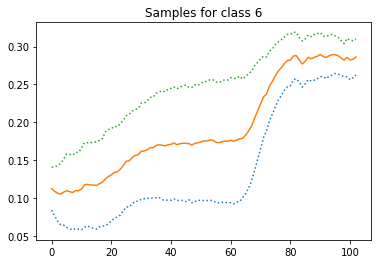

 31%|███       | 31000/100000 [47:48<1:46:25, 10.81it/s]

Iter-31000; D_loss: -0.005982400383800268; G_loss: -0.10564965754747391; C_loss: 0.00831521861255169


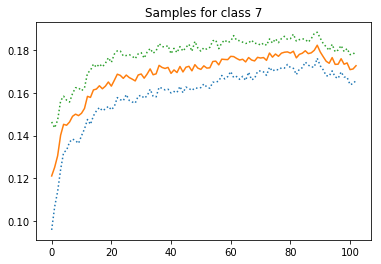

 32%|███▏      | 32000/100000 [49:21<1:44:53, 10.80it/s]

Iter-32000; D_loss: -0.008043641224503517; G_loss: -0.07392570376396179; C_loss: 0.015567242167890072


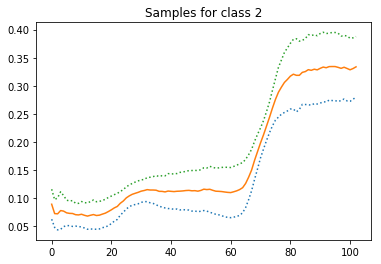

 33%|███▎      | 32999/100000 [50:54<1:43:22, 10.80it/s]

Iter-33000; D_loss: -0.012638633139431477; G_loss: -0.10574228316545486; C_loss: 0.008193441666662693


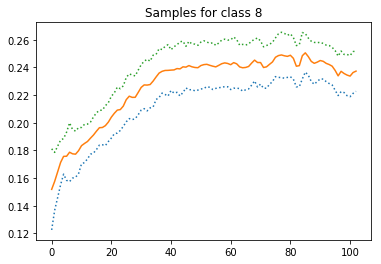

 34%|███▍      | 33999/100000 [52:27<1:41:50, 10.80it/s]

Iter-34000; D_loss: -0.007851064205169678; G_loss: -0.08952856808900833; C_loss: 0.012773782014846802


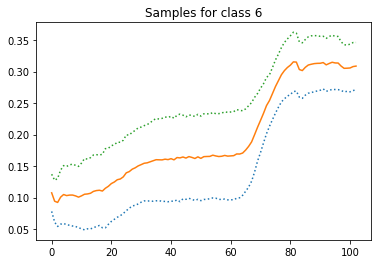

 35%|███▍      | 34999/100000 [53:59<1:40:17, 10.80it/s]

Iter-35000; D_loss: -0.007195344194769859; G_loss: -0.09902100265026093; C_loss: 0.029682721942663193


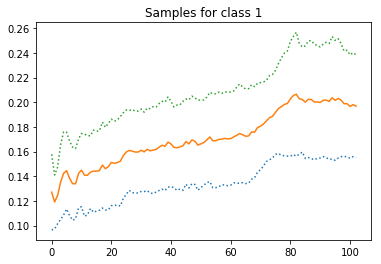

 36%|███▌      | 35999/100000 [55:32<1:38:45, 10.80it/s]

Iter-36000; D_loss: -0.010245893150568008; G_loss: -0.07795669883489609; C_loss: 0.02148476615548134


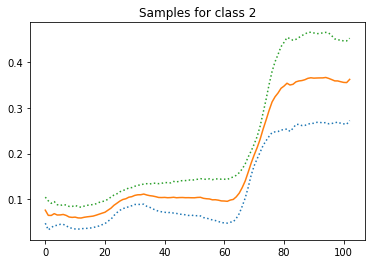

 37%|███▋      | 36999/100000 [57:05<1:37:12, 10.80it/s]

Iter-37000; D_loss: 0.004441951867192984; G_loss: -0.11899410933256149; C_loss: 0.015337478369474411


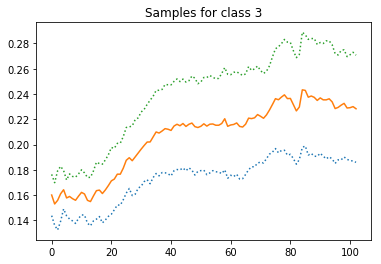

 38%|███▊      | 38000/100000 [58:38<1:35:40, 10.80it/s]

Iter-38000; D_loss: 0.0020617851987481117; G_loss: -0.09935824573040009; C_loss: 0.01600676402449608


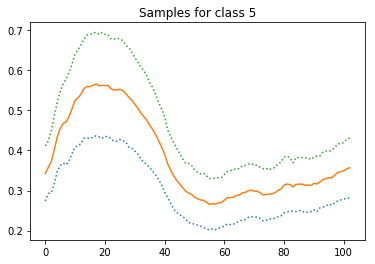

 39%|███▉      | 38999/100000 [1:00:10<1:34:07, 10.80it/s]

Iter-39000; D_loss: -0.010004145093262196; G_loss: -0.09934810549020767; C_loss: 0.017917625606060028


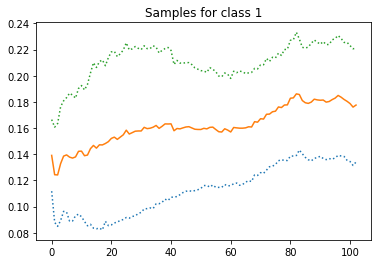

 40%|████      | 40000/100000 [1:01:43<1:32:34, 10.80it/s]

Iter-40000; D_loss: -0.008458372205495834; G_loss: -0.09458116441965103; C_loss: 0.014200805686414242


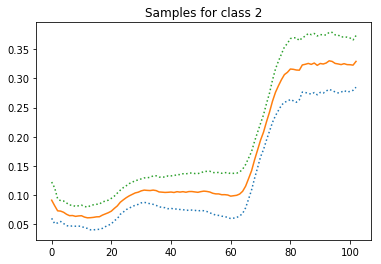

 41%|████      | 40999/100000 [1:03:16<1:31:03, 10.80it/s]

Iter-41000; D_loss: -0.006597346626222134; G_loss: -0.10621759295463562; C_loss: 0.012278747744858265


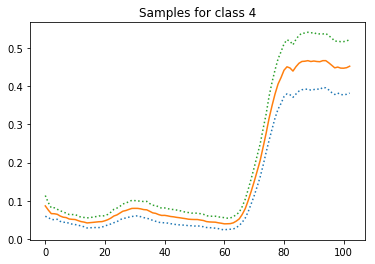

 42%|████▏     | 42000/100000 [1:04:50<1:29:32, 10.80it/s]

Iter-42000; D_loss: -0.01670948602259159; G_loss: -0.10430911183357239; C_loss: 0.011436519213020802


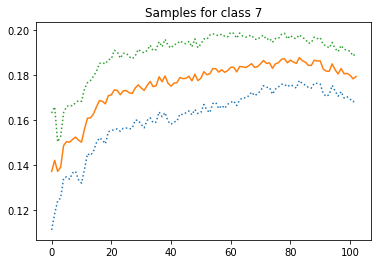

 43%|████▎     | 43000/100000 [1:06:23<1:28:00, 10.80it/s]

Iter-43000; D_loss: -0.008089162409305573; G_loss: -0.1147129163146019; C_loss: 0.017624113708734512


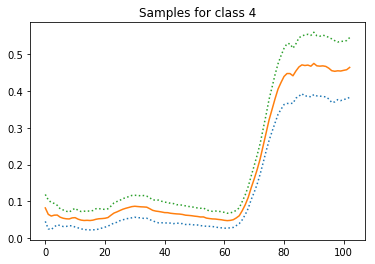

 44%|████▍     | 43999/100000 [1:07:56<1:26:28, 10.79it/s]

Iter-44000; D_loss: -0.01125426683574915; G_loss: -0.09332431852817535; C_loss: 0.01166242640465498


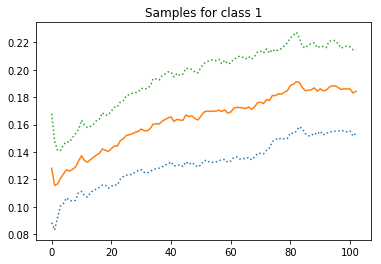

 45%|████▍     | 44999/100000 [1:09:30<1:24:56, 10.79it/s]

Iter-45000; D_loss: -0.0029728193767368793; G_loss: -0.0864536315202713; C_loss: 0.017545048147439957


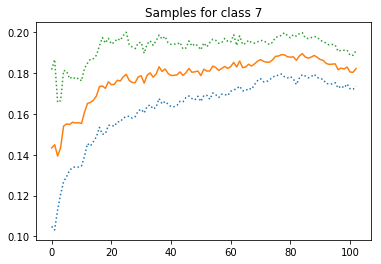

 46%|████▌     | 46000/100000 [1:11:09<1:23:31, 10.77it/s]

Iter-46000; D_loss: -0.015400909818708897; G_loss: -0.1081405058503151; C_loss: 0.012497786432504654


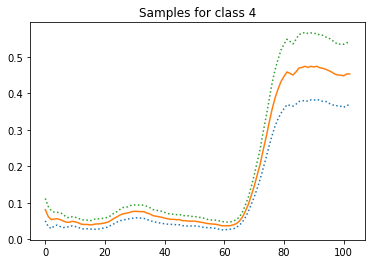

 47%|████▋     | 47000/100000 [1:12:48<1:22:06, 10.76it/s]

Iter-47000; D_loss: -0.011951448395848274; G_loss: -0.09296707063913345; C_loss: 0.014480261132121086


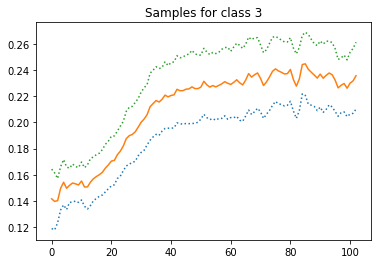

 48%|████▊     | 47999/100000 [1:14:22<1:20:34, 10.76it/s]

Iter-48000; D_loss: -0.010645220056176186; G_loss: -0.09700805693864822; C_loss: 0.01286612544208765


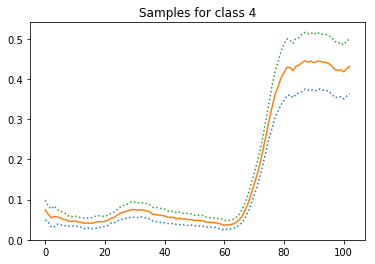

 49%|████▉     | 48999/100000 [1:15:55<1:19:01, 10.76it/s]

Iter-49000; D_loss: -0.010535215958952904; G_loss: -0.10540646314620972; C_loss: 0.01287997979670763


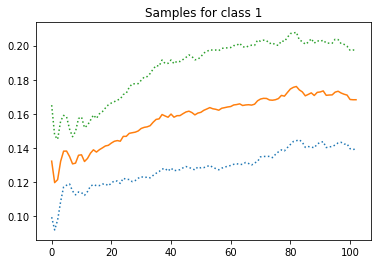

 50%|█████     | 50000/100000 [1:17:28<1:17:28, 10.76it/s]

Iter-50000; D_loss: -0.007456453517079353; G_loss: -0.11636140197515488; C_loss: 0.010026475414633751


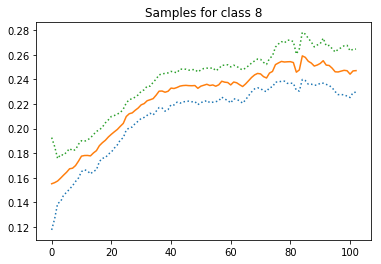

 51%|█████     | 50999/100000 [1:19:00<1:15:54, 10.76it/s]

Iter-51000; D_loss: -0.011655973270535469; G_loss: -0.098928302526474; C_loss: 0.01115731056779623


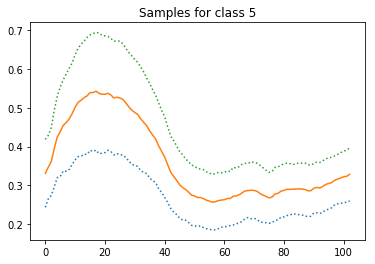

 52%|█████▏    | 51999/100000 [1:20:32<1:14:20, 10.76it/s]

Iter-52000; D_loss: -0.01263843011111021; G_loss: -0.10171783715486526; C_loss: 0.013619717210531235


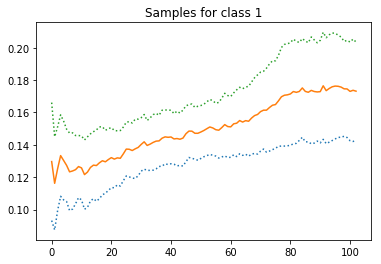

 53%|█████▎    | 52999/100000 [1:22:03<1:12:45, 10.77it/s]

Iter-53000; D_loss: -0.01444825530052185; G_loss: -0.09293617308139801; C_loss: 0.009141835384070873


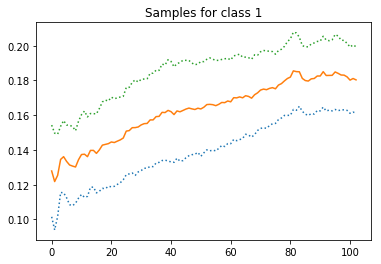

 54%|█████▍    | 53999/100000 [1:23:34<1:11:11, 10.77it/s]

Iter-54000; D_loss: -0.01344999484717846; G_loss: -0.10273224115371704; C_loss: 0.009773879311978817


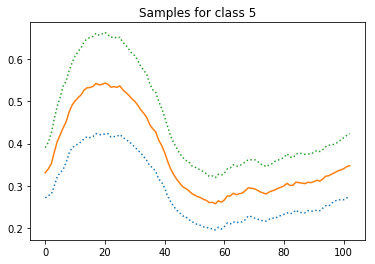

 55%|█████▍    | 54999/100000 [1:25:05<1:09:37, 10.77it/s]

Iter-55000; D_loss: -0.015715092420578003; G_loss: -0.08318565785884857; C_loss: 0.010780444368720055


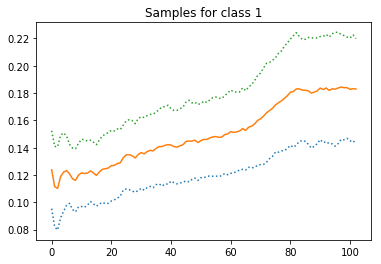

 56%|█████▌    | 55999/100000 [1:26:35<1:08:02, 10.78it/s]

Iter-56000; D_loss: -0.013657934963703156; G_loss: -0.09674568474292755; C_loss: 0.02359398454427719


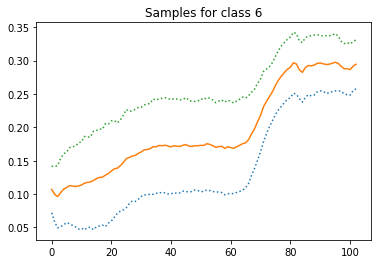

 57%|█████▋    | 57000/100000 [1:28:07<1:06:28, 10.78it/s]

Iter-57000; D_loss: -0.012787647545337677; G_loss: -0.10343830287456512; C_loss: 0.011854665353894234


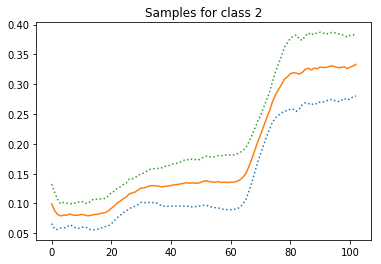

 58%|█████▊    | 58000/100000 [1:29:38<1:04:55, 10.78it/s]

Iter-58000; D_loss: -0.0010122526437044144; G_loss: -0.09832850098609924; C_loss: 0.010895316489040852


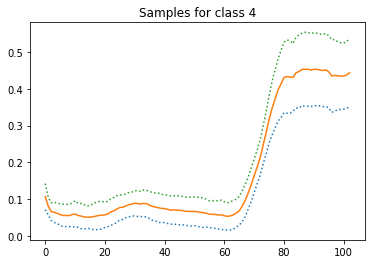

 59%|█████▉    | 59000/100000 [1:31:10<1:03:21, 10.79it/s]

Iter-59000; D_loss: -0.008709840476512909; G_loss: -0.09750419110059738; C_loss: 0.014555091969668865


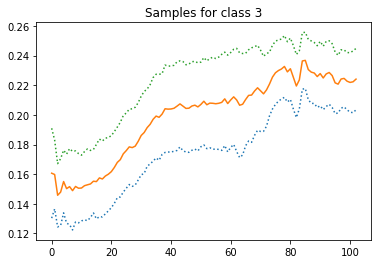

 60%|█████▉    | 59999/100000 [1:32:40<1:01:47, 10.79it/s]

Iter-60000; D_loss: -0.012468943372368813; G_loss: -0.11733897030353546; C_loss: 0.009036927483975887


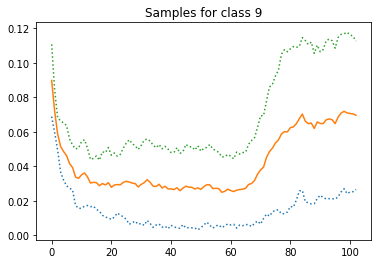

 61%|██████    | 61000/100000 [1:34:12<1:00:13, 10.79it/s]

Iter-61000; D_loss: -0.006709539797157049; G_loss: -0.10163712501525879; C_loss: 0.015299580991268158


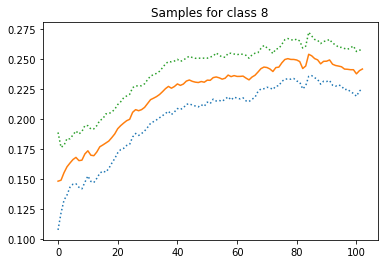

 62%|██████▏   | 62000/100000 [1:35:43<58:40, 10.80it/s]  

Iter-62000; D_loss: -0.00805285107344389; G_loss: -0.1048453077673912; C_loss: 0.01705005392432213


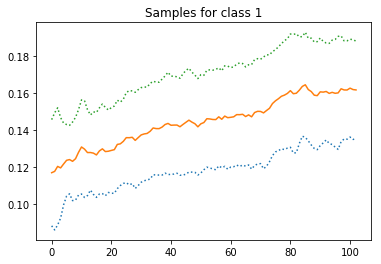

 63%|██████▎   | 63000/100000 [1:37:14<57:06, 10.80it/s]

Iter-63000; D_loss: -0.012975574471056461; G_loss: -0.09655946493148804; C_loss: 0.010916799306869507


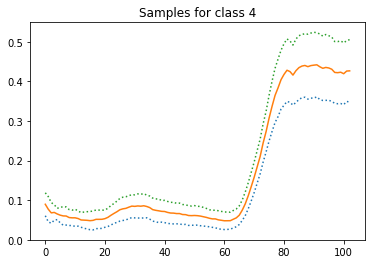

 64%|██████▍   | 64000/100000 [1:38:45<55:32, 10.80it/s]

Iter-64000; D_loss: -0.013284320011734962; G_loss: -0.10103965550661087; C_loss: 0.011290762573480606


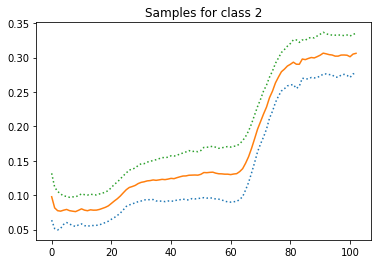

 65%|██████▌   | 65000/100000 [1:40:16<53:59, 10.80it/s]

Iter-65000; D_loss: -0.012293742038309574; G_loss: -0.10411123186349869; C_loss: 0.010996622033417225


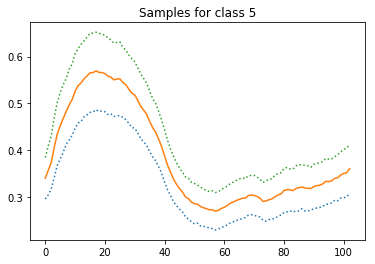

 66%|██████▌   | 66000/100000 [1:41:47<52:26, 10.81it/s]

Iter-66000; D_loss: -0.010543489828705788; G_loss: -0.11960351467132568; C_loss: 0.009888334199786186


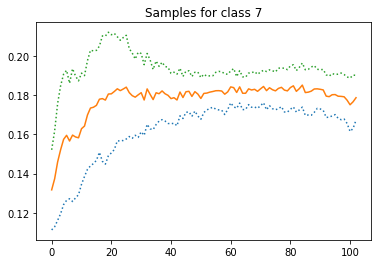

 67%|██████▋   | 66999/100000 [1:43:18<50:53, 10.81it/s]

Iter-67000; D_loss: -0.008702663704752922; G_loss: -0.12500736117362976; C_loss: 0.008397210389375687


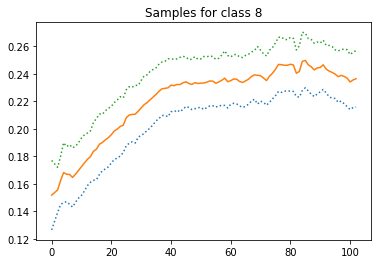

 68%|██████▊   | 67999/100000 [1:44:49<49:19, 10.81it/s]

Iter-68000; D_loss: -0.012543471530079842; G_loss: -0.11481665074825287; C_loss: 0.00899857934564352


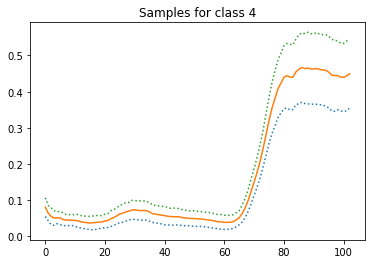

 69%|██████▉   | 69000/100000 [1:46:21<47:46, 10.81it/s]

Iter-69000; D_loss: -0.007706454489380121; G_loss: -0.10450509935617447; C_loss: 0.016008850187063217


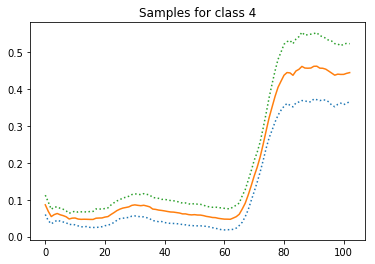

 70%|███████   | 70000/100000 [1:47:52<46:14, 10.81it/s]

Iter-70000; D_loss: -0.011099504306912422; G_loss: -0.09324727207422256; C_loss: 0.011401543393731117


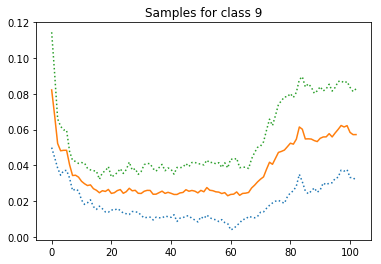

 71%|███████   | 70999/100000 [1:49:25<44:41, 10.81it/s]

Iter-71000; D_loss: -0.011209939606487751; G_loss: -0.10743100941181183; C_loss: 0.01814660057425499


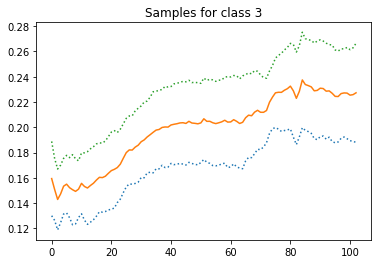

 72%|███████▏  | 71999/100000 [1:51:00<43:10, 10.81it/s]

Iter-72000; D_loss: -0.009885195642709732; G_loss: -0.11529555916786194; C_loss: 0.01185351237654686


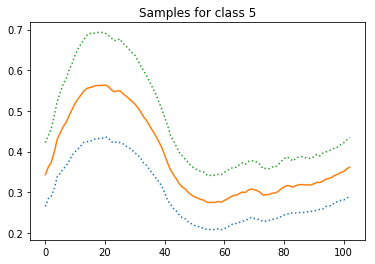

 73%|███████▎  | 73000/100000 [1:52:31<41:37, 10.81it/s]

Iter-73000; D_loss: -0.009352981112897396; G_loss: -0.12079448252916336; C_loss: 0.010974242351949215


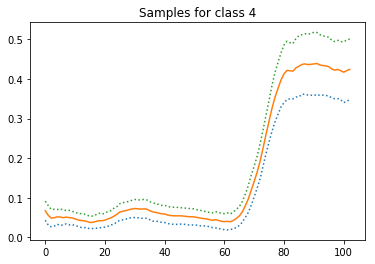

 74%|███████▍  | 73999/100000 [1:54:03<40:04, 10.81it/s]

Iter-74000; D_loss: -0.012327505275607109; G_loss: -0.10176785290241241; C_loss: 0.018049903213977814


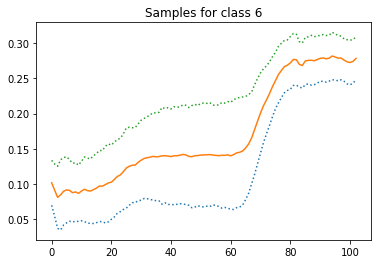

 75%|███████▍  | 74999/100000 [1:55:35<38:31, 10.81it/s]

Iter-75000; D_loss: -0.011560631915926933; G_loss: -0.09024398773908615; C_loss: 0.013239688239991665


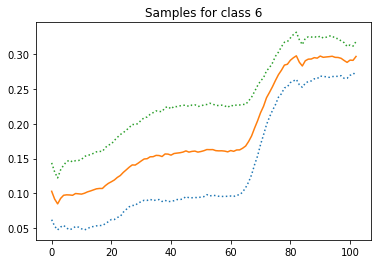

 76%|███████▌  | 75999/100000 [1:57:07<36:59, 10.81it/s]

Iter-76000; D_loss: -0.011584101244807243; G_loss: -0.11105812340974808; C_loss: 0.010715099051594734


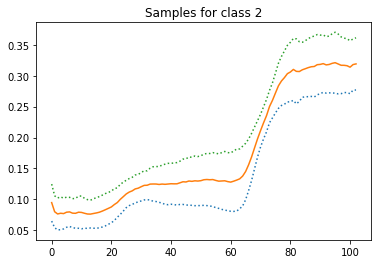

 77%|███████▋  | 77000/100000 [1:58:39<35:26, 10.81it/s]

Iter-77000; D_loss: -0.009388050995767117; G_loss: -0.11148941516876221; C_loss: 0.012550882995128632


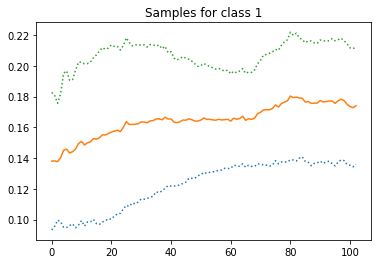

 78%|███████▊  | 78000/100000 [2:00:12<33:54, 10.81it/s]

Iter-78000; D_loss: -0.011363268829882145; G_loss: -0.10539080202579498; C_loss: 0.009085357189178467


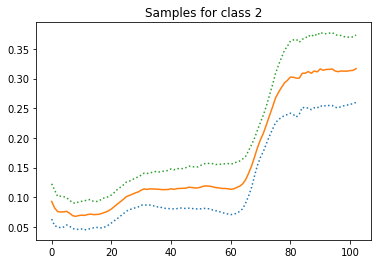

 79%|███████▉  | 79000/100000 [2:01:43<32:21, 10.82it/s]

Iter-79000; D_loss: -0.011724940501153469; G_loss: -0.11676078289747238; C_loss: 0.011216389946639538


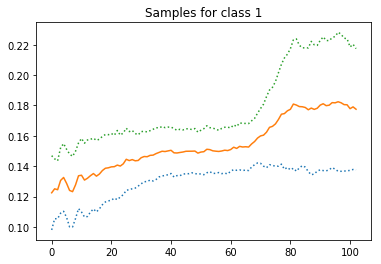

 80%|███████▉  | 79999/100000 [2:03:16<30:49, 10.82it/s]

Iter-80000; D_loss: -0.012241489253938198; G_loss: -0.12230263650417328; C_loss: 0.006931618321686983


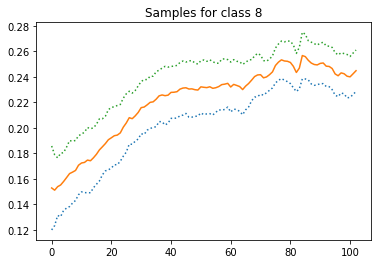

 81%|████████  | 81000/100000 [2:04:50<29:17, 10.81it/s]

Iter-81000; D_loss: -0.011680584400892258; G_loss: -0.11066555231809616; C_loss: 0.015957724303007126


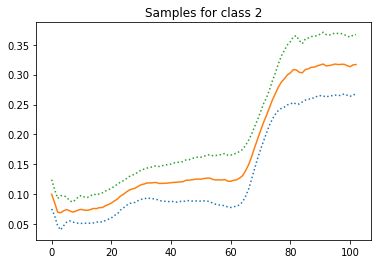

 82%|████████▏ | 82000/100000 [2:06:21<27:44, 10.82it/s]

Iter-82000; D_loss: -0.00951260793954134; G_loss: -0.12024104595184326; C_loss: 0.0075765736401081085


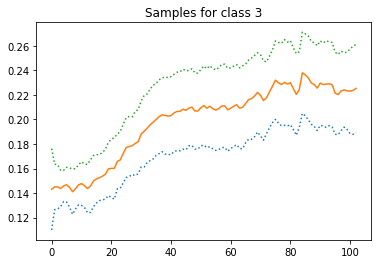

 83%|████████▎ | 82999/100000 [2:07:53<26:11, 10.82it/s]

Iter-83000; D_loss: -0.0065779616124928; G_loss: -0.10406485199928284; C_loss: 0.013020835816860199


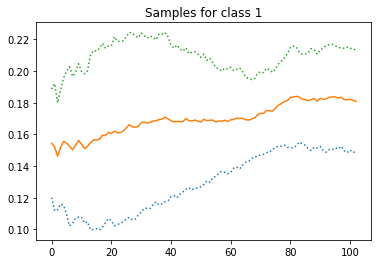

 84%|████████▍ | 84000/100000 [2:09:24<24:38, 10.82it/s]

Iter-84000; D_loss: -0.012836586683988571; G_loss: -0.10423015058040619; C_loss: 0.012211228720843792


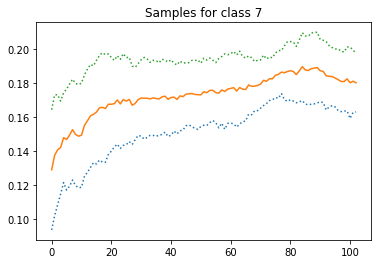

 85%|████████▌ | 85000/100000 [2:10:58<23:06, 10.82it/s]

Iter-85000; D_loss: -0.011663136072456837; G_loss: -0.1292775422334671; C_loss: 0.010259157046675682


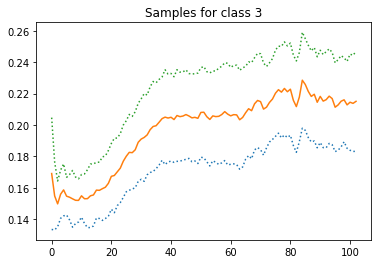

 86%|████████▌ | 85999/100000 [2:12:33<21:34, 10.81it/s]

Iter-86000; D_loss: -0.012920447625219822; G_loss: -0.12888209521770477; C_loss: 0.006800220347940922


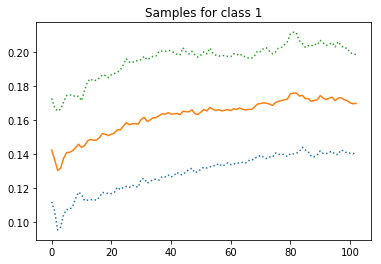

 87%|████████▋ | 87000/100000 [2:14:06<20:02, 10.81it/s]

Iter-87000; D_loss: -0.011864014901220798; G_loss: -0.12779714167118073; C_loss: 0.007267611101269722


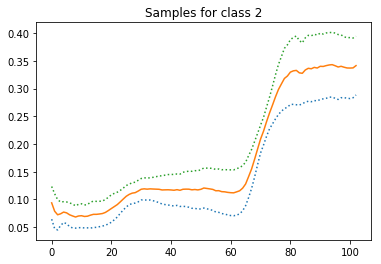

 88%|████████▊ | 87999/100000 [2:15:39<18:30, 10.81it/s]

Iter-88000; D_loss: -0.009598360396921635; G_loss: -0.12702862918376923; C_loss: 0.008739245124161243


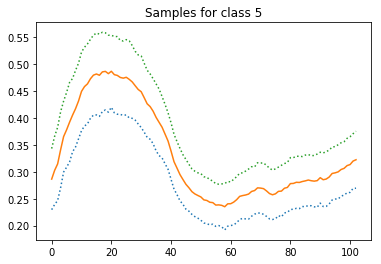

 89%|████████▉ | 89000/100000 [2:17:11<16:57, 10.81it/s]

Iter-89000; D_loss: -0.013669642619788647; G_loss: -0.1514749526977539; C_loss: 0.010534494183957577


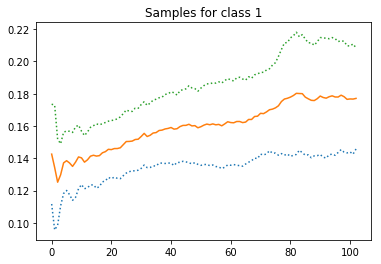

 90%|█████████ | 90000/100000 [2:18:48<15:25, 10.81it/s]

Iter-90000; D_loss: -0.00666424073278904; G_loss: -0.14390289783477783; C_loss: 0.010380959138274193


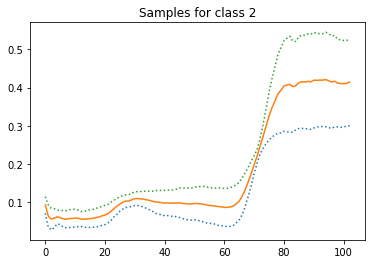

 91%|█████████ | 91000/100000 [2:20:29<13:53, 10.79it/s]

Iter-91000; D_loss: -0.010225829668343067; G_loss: -0.14218607544898987; C_loss: 0.007597317453473806


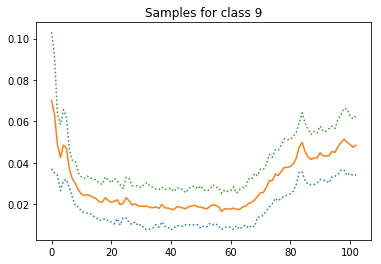

 92%|█████████▏| 91999/100000 [2:22:11<12:21, 10.78it/s]

Iter-92000; D_loss: -0.01485922746360302; G_loss: -0.13999295234680176; C_loss: 0.009712479077279568


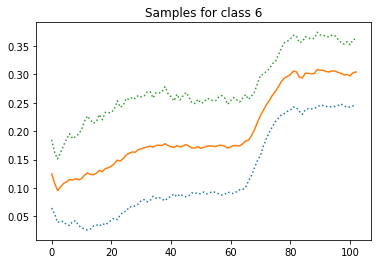

 93%|█████████▎| 92999/100000 [2:23:50<10:49, 10.78it/s]

Iter-93000; D_loss: -0.011750049889087677; G_loss: -0.13695907592773438; C_loss: 0.01229435671120882


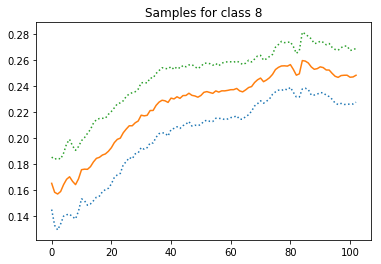

 94%|█████████▍| 94000/100000 [2:25:33<09:17, 10.76it/s]

Iter-94000; D_loss: -0.015713617205619812; G_loss: -0.13461370766162872; C_loss: 0.017991654574871063


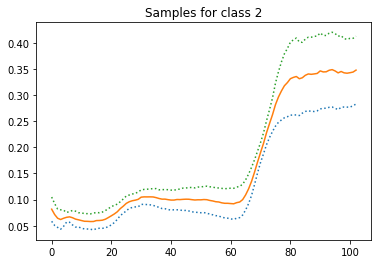

 95%|█████████▍| 94999/100000 [2:27:16<07:45, 10.75it/s]

Iter-95000; D_loss: -0.00917360931634903; G_loss: -0.13940264284610748; C_loss: 0.009797914884984493


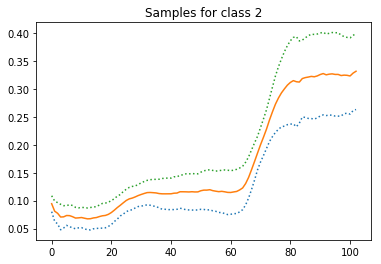

 96%|█████████▌| 96000/100000 [2:28:52<06:12, 10.75it/s]

Iter-96000; D_loss: -0.004659915808588266; G_loss: -0.1429736465215683; C_loss: 0.045481182634830475


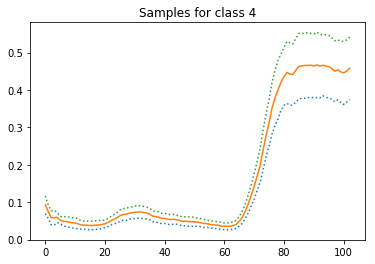

 97%|█████████▋| 96999/100000 [2:30:28<04:39, 10.74it/s]

Iter-97000; D_loss: -0.007580975070595741; G_loss: -0.13828912377357483; C_loss: 0.012335647828876972


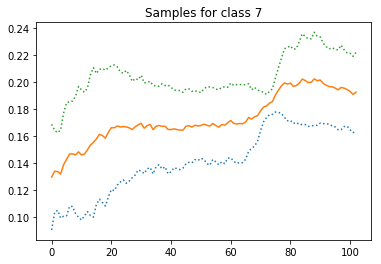

 98%|█████████▊| 97999/100000 [2:32:04<03:06, 10.74it/s]

Iter-98000; D_loss: -0.011023599654436111; G_loss: -0.1464119851589203; C_loss: 0.005648434162139893


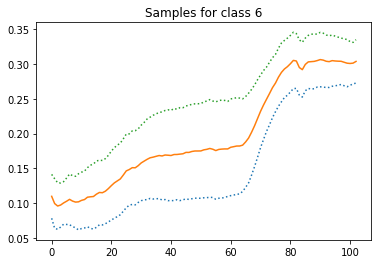

 99%|█████████▉| 98999/100000 [2:33:41<01:33, 10.74it/s]

Iter-99000; D_loss: -0.015276055783033371; G_loss: -0.136368989944458; C_loss: 0.01091157179325819


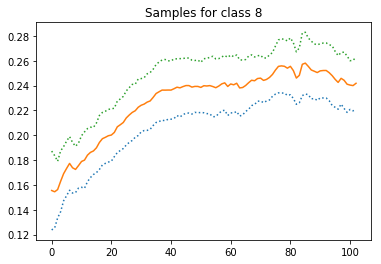

100%|██████████| 100000/100000 [2:35:19<00:00, 10.73it/s]


In [8]:
# Get networks
G = Generator().cuda()
D = Discriminator().cuda()
C = Classifier().cuda()
# Use RMSProp optimizer
G_solver = optim.RMSprop(G.parameters(), lr=lr)
D_solver = optim.RMSprop(D.parameters(), lr=lr)
C_solver = optim.RMSprop(C.parameters(), lr=lr)

for it in tqdm(range(100000)):
    ###########################
    # (1) Update C and D      #
    ###########################
    for p in D.parameters():  # reset requires_grad
        p.requires_grad = True  # they are set to False below in netG update
    for p in C.parameters():
        p.requires_grad = True
    
    # D is trained d_step times for each iteration
    for _, (X, y), (X_, y_) in zip(range(d_step), data_loader, data_loader):
        D.zero_grad()

        # Sample random noise
        z = torch.randn(y.size(0), z_dim).squeeze()
        X, y = X.float(), y.float()
        X_, y_ = X_.float(), y_.float()
        # Mixup
        lam = np.random.beta(mixup_alpha, mixup_alpha)
        X = lam*X + (1. - lam)*X_
        X, y, z = X.cuda(), y.cuda(), z.cuda()
        y_ = y_.cuda()
        
        # Get discriminator prediction on real samples
        D_real = D(X).mean()
        # Get discriminator prediction on fake samples
        fake_samples = G(z, y)
        D_fake = D(fake_samples).mean()
        # Compute gradient penalty
        gradient_penalty = calc_gradient_penalty(D, X.data, fake_samples.data)
        # Compute loss and backpropagate
        D_loss = D_fake - D_real + gradient_penalty
        flip = np.random.random() < flip_percentage
        if flip: 
            # Flip real and fake
            gradient_penalty = calc_gradient_penalty(D, fake_samples.data, X.data)
            D_loss = D_real - D_fake + gradient_penalty
        D_loss.backward()
        D_solver.step()
    
        ######################
        #  Update C network  #
        ######################
        C.zero_grad()
        # Get class values
        _, classes = torch.max(y, dim=1)
        _, classes_ = torch.max(y_, dim=1)
        # Get predictions from C
        if flip:
            fake_samples = G(z, y)
            pred = C(fake_samples)
            # Compute loss and backpropagate
            C_loss = F.cross_entropy(pred, classes, weight=class_weights)
        else:
            pred = F.log_softmax(C(X))
            C_loss = lam * F.nll_loss(pred, classes) + (1. - lam) * F.nll_loss(pred, classes_)
        C_loss.backward()
        C_solver.step()


    ############################
    # (2) Update G network
    ###########################
    for p in D.parameters():
        p.requires_grad = False  # to avoid computation
    for p in C.parameters():
        p.requires_grad = False
    reset_grad(C, G, D)

    # Sample random noise
    z = torch.randn(y.size(0), z_dim).squeeze()
    z = z.cuda()
    # Generate fake samples
    G_sample = G(z, y)
    D_fake = D(G_sample)
    pred = C(G_sample)
    C_loss = F.cross_entropy(pred, classes, weight=class_weights)
    # Fool the discriminator (WGAN)
    G_loss = -torch.mean(D_fake)
    # Include the auxialiary classifier loss (AC-GAN)
    loss = G_loss + c_weight * C_loss
    # Backpropagate
    loss.backward()
    G_solver.step()

    # Print and plot every now and then
    if it % 1000 == 0:
        with torch.no_grad():
            print('Iter-{}; D_loss: {}; G_loss: {}; C_loss: {}'.format(it,
                                                           D_loss.data.cpu().numpy(), G_loss.data.cpu().numpy(),
                                                           C_loss.data.cpu().numpy()))
            z = torch.randn(mb_size, z_dim).squeeze().cuda()
            c = np.zeros(shape=[mb_size, c_dim], dtype='float32')
            idx = np.random.randint(1, data_loader.dataset.n_classes)
            c[:, idx] = 1.
            c = torch.from_numpy(c).squeeze().cuda()
            samples = G(z, c).data.cpu().numpy()[:16]
            pred = G(z, c)
            plot_mean_std(samples)
            plt.title("Samples for class {}".format(idx))
            plt.show()

## Data generation

Now that the generator has been trained, we can generate some fake spectra and see how they fare visually against the real ones.

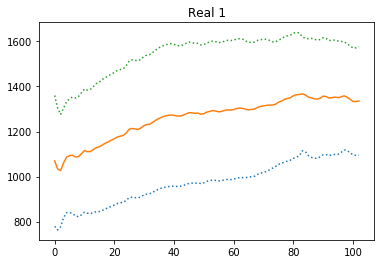

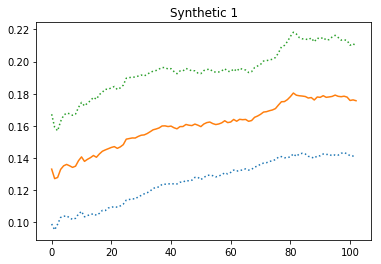

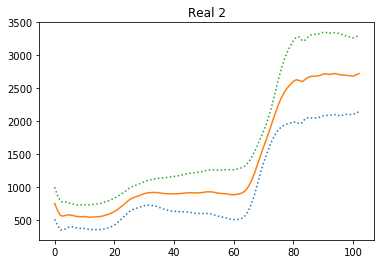

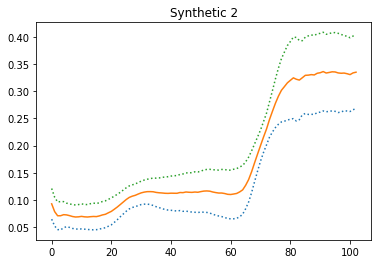

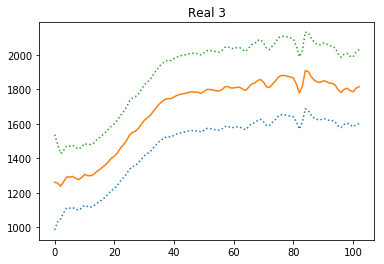

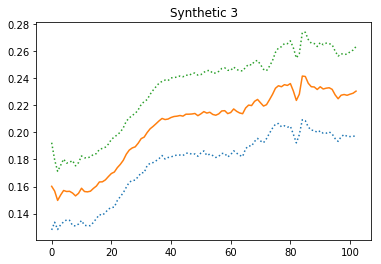

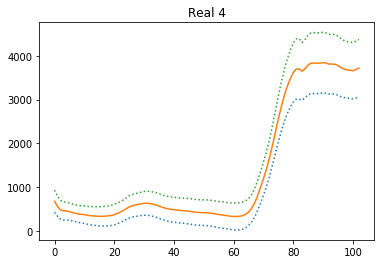

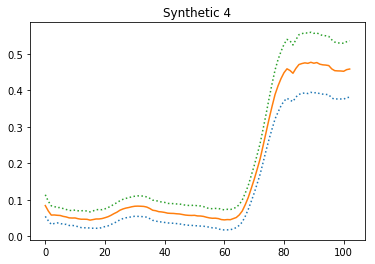

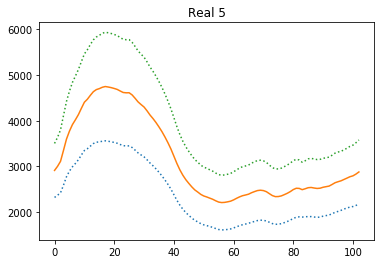

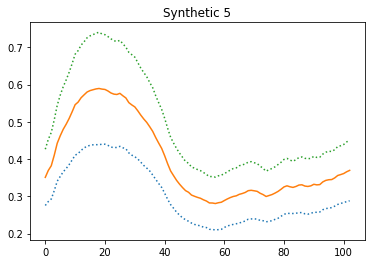

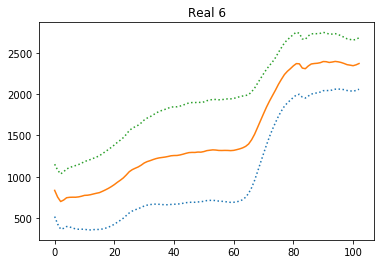

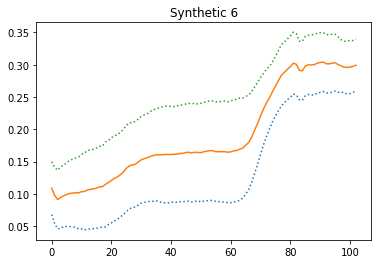

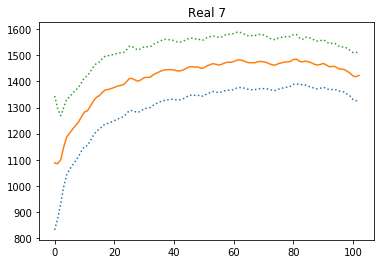

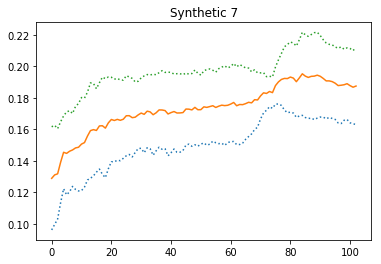

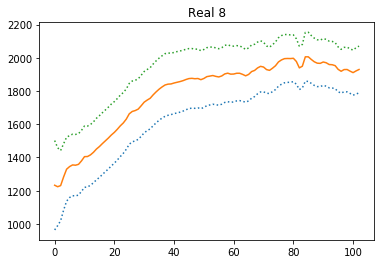

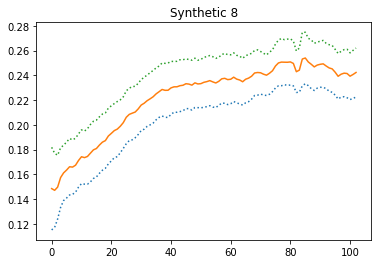

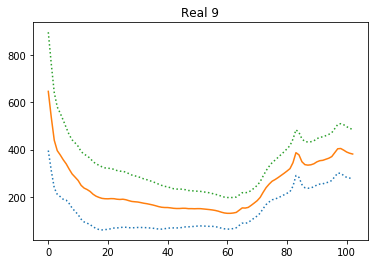

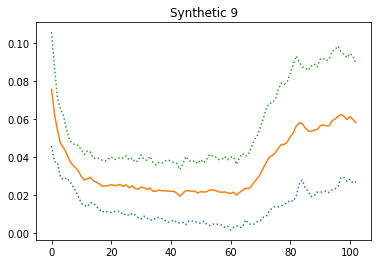

In [9]:
for c in np.unique(gt):
    # 0 is the "undefined" class
    if c == 0:
        continue
    
    # Get the mean spectrum +- std for this class
    spectras = img[gt == c, :]
    plot_mean_std(spectras)
    plt.title("Real {}".format(c))
    plt.show()
    
    # Get as many fake spectras as real ones
    synthetic_spectras = []
    with torch.no_grad():
        while len(synthetic_spectras) < len(spectras):
            z = torch.randn(mb_size, z_dim).cuda()
            y = torch.from_numpy(np.eye(data_loader.dataset.n_classes)[c]).float()
            y = y.unsqueeze(0).repeat(mb_size, 1).cuda()
            G_sample = G(z, y)
            _, classes = torch.max(y, 1)
            _, pred = torch.max(C(G_sample), 1)
            synthetic_spectras += list(G_sample.cpu().data.numpy())
    plt.show()
    plot_mean_std(synthetic_spectras)
    plt.title("Synthetic {}".format(c))
    plt.show()

## Evaluation

Finally, we want to compare the two distributions: is the fake distribution truely similar to the real distribution? To this end, we first can train a linear SVM on the real data and then apply it on the fake data. The frontiers of the real data should be respected by the fake data if the learning was successful.

In [10]:
import sklearn.svm
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.pipeline
import sklearn.mixture

In [11]:
img = (img - img.min()) / (img.max() - img.min())
X_train = np.array([img[x,y] for x,y in zip(*np.nonzero(train_gt))])
y_train = np.array([gt[x,y] for x,y in zip(*np.nonzero(train_gt))])
X_test = np.array([img[x,y] for x,y in zip(*np.nonzero(test_gt))])
y_test = np.array([test_gt[x,y] for x,y in zip(*np.nonzero(test_gt))])

In [12]:
gmms = [sklearn.mixture.GaussianMixture(n_components=20) for _ in range(c_dim)]
for y in np.unique(y_train):
    gmms[y].fit(X_train[y_train == y])

We can uncomment this code to use Gaussian Mixture Models instead of GANs.

In [13]:
def gmm_create_fake_dataset(gmms, y):
    fake_X = []
    y_fake = []
    for y in np.unique(y):
        n_samples = np.count_nonzero(y_test == y)
        samples = gmms[y].sample(n_samples)[0]
        fake_X.append(samples)
        y_fake += [y] * n_samples
    fake_X = np.concatenate(fake_X)
    y_fake = np.array(y_fake)
    return fake_X, y_fake

#fake_X_train, fake_y_train = gmm_create_fake_dataset(gmms, y_train)
#fake_X_test, fake_y_test = gmm_create_fake_dataset(gmms, y_test)

### SVM on real data

Let's train a linear SVM on real data and see how it performs.

In [14]:
scaler = sklearn.preprocessing.StandardScaler()
svm = sklearn.svm.SVC()
#estimator = sklearn.pipeline.Pipeline(steps=[('scaler', scaler), ('svm', svm)])
estimator = sklearn.pipeline.Pipeline(steps=[('svm', svm)])
#tuned_parameters = {'svm__C': [0.1, 1, 10, 100, 1000], 'svm__kernel': ['linear']}
tuned_parameters = {'svm__C': [1000], 'svm__kernel': ['linear']}
clf = sklearn.model_selection.GridSearchCV(estimator, tuned_parameters, cv=5, n_jobs=4)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
best_params = clf.best_params_
print("The best SVM was obtained using {} and performed at {:.2f} accuracy.".format(best_params, 100 * score))

The best SVM was obtained using {'svm__C': 1000, 'svm__kernel': 'linear'} and performed at 89.63 accuracy.


In [15]:
y_pred = clf.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          1       0.85      0.94      0.89      6310
          2       0.93      0.96      0.94     17716
          3       0.79      0.72      0.75      2007
          4       0.93      0.90      0.91      2926
          5       1.00      1.00      1.00      1276
          6       0.87      0.78      0.82      4795
          7       0.83      0.48      0.61      1273
          8       0.83      0.84      0.84      3501
          9       1.00      1.00      1.00       891

avg / total       0.89      0.90      0.89     40695



### SVM on fake data

We now generate some fake data (in the same quantities as the real data) and apply the trained SVM on it.

In [16]:
def gan_create_fake_dataset(labels):
    with torch.no_grad():
        spectras = []
        for l in np.array_split(labels, len(labels) // mb_size):
            z = torch.randn(len(l), z_dim).cuda()
            y = np.zeros((len(l), data_loader.dataset.n_classes))
            for i, label in enumerate(l):
                y[i] = np.eye(data_loader.dataset.n_classes)[label]
            y = torch.from_numpy(y).float()
            eps = torch.randn(y.size())/10
            #y += eps
            y = y.cuda()
            G_sample = G(z, y)
            spectras += list(G_sample.cpu().data.numpy())
        return np.array(spectras), np.array(labels)

In [17]:
fake_X_train, fake_y_train = gan_create_fake_dataset(y_train)
fake_X_test, fake_y_test = gan_create_fake_dataset(y_test)

The true SVM performs better on fake data. Fake data is easier to separate, which means that it does not capture well boundaries between classes.

In [18]:
clf.score(fake_X_test, fake_y_test)

0.959429905393783

In [19]:
y_fake_pred = clf.predict(fake_X_test)
from sklearn.metrics import classification_report
print(classification_report(fake_y_test, y_fake_pred))

             precision    recall  f1-score   support

          1       0.92      0.96      0.94      6310
          2       0.97      0.99      0.98     17716
          3       0.97      0.88      0.92      2007
          4       0.99      0.96      0.98      2926
          5       0.96      1.00      0.98      1276
          6       0.95      0.93      0.94      4795
          7       0.93      0.65      0.77      1273
          8       0.94      0.96      0.95      3501
          9       1.00      0.95      0.97       891

avg / total       0.96      0.96      0.96     40695



We can also train a "fake" SVM on fake data. It separates the fake data nearly perfectly. However, it also neatly separates the true data. It is not as good as the true SVM, but still relatively good for synthetic data.

In [20]:
svm_fake = sklearn.svm.SVC()
clf_fake = sklearn.pipeline.Pipeline(steps=[('svm', svm_fake)])
clf_fake.set_params(**clf.best_params_)
clf_fake.fit(np.concatenate([fake_X_train]), np.concatenate([fake_y_train]))

Pipeline(memory=None,
     steps=[('svm', SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [21]:
clf_fake.score(fake_X_test, fake_y_test)

0.992652660031945

In [22]:
clf_fake.score(X_test, y_test)

0.8802801326944342

## Data augmentation

We can train on both real and fake data to use the latter as augmented data. However, as we saw the fake data does not capture class boundaries very well. Therefore, it only skews the SVM and worsen the accuracy.

In [23]:
svm_augmented = sklearn.svm.SVC()
#clf_augmented = sklearn.pipeline.Pipeline(steps=[('scaler', scaler), ('svm', svm_augmented)])
clf_augmented = sklearn.pipeline.Pipeline(steps=[('svm', svm_augmented)])
clf_augmented.set_params(**clf.best_params_)
clf_augmented.fit(np.concatenate([X_train, fake_X_train]), np.concatenate([y_train, fake_y_train]))

Pipeline(memory=None,
     steps=[('svm', SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [24]:
clf_augmented.score(X_test, y_test)

0.8910185526477454

## Statistical analysis

We can apply a PCA to both the real and fake datasets to visually compare them. The distributions in the 2D main components are fairly similar, which is good!

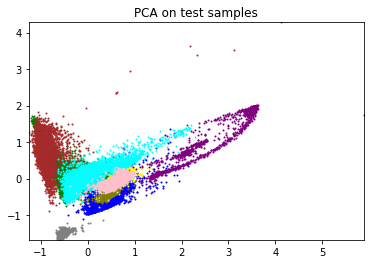

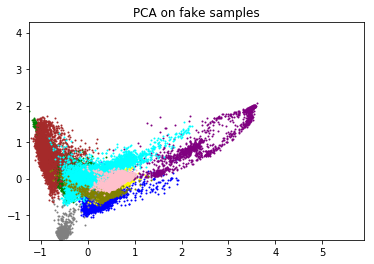

In [25]:
%matplotlib inline
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test)
x_min, x_max = np.min(X_pca[:,0]), np.max(X_pca[:,0])
y_min, y_max = np.min(X_pca[:,1]), np.max(X_pca[:,1])

colors = ['red', 'blue', 'green', 'yellow', 'brown', 'purple', 'cyan', 'olive', 'pink', 'gray']
for i, color in enumerate(colors):
    idx = y_test == i
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], c=color, s=1)
    plt.ylim(y_min, y_max)
    plt.xlim(x_min, x_max)
    plt.title('PCA on test samples')
plt.show()

X_fake_pca = pca.transform(fake_X_test)
for i, color in enumerate(colors):
    idx = fake_y_test == i
    plt.scatter(X_fake_pca[idx, 0], X_fake_pca[idx, 1], s=1, c=color)
    plt.ylim(y_min, y_max)
    plt.xlim(x_min, x_max)
    plt.title('PCA on fake samples')
plt.show()

We can train a neural network classifier on the real dataset and the augmented dataset (real + fake).

In [1]:
def train(net, X_train, y_train, epochs=100):
    dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_train).float(),
                                             torch.from_numpy(y_train).long())
    loader = torch.utils.data.DataLoader(dataset, batch_size=1024, shuffle=True)
    solver = optim.Adam(net.parameters(), amsgrad=True)
    net.train()
    it = 0
    losses = []
    for _ in tqdm(range(epochs)):
        for X, y in loader:
            it += 1
            net.zero_grad()
            X, y = X.cuda(), y.cuda()
            out = net(X)
            loss = F.cross_entropy(out, y)
            loss.backward()
            solver.step()
            losses.append(loss.item())
            if it % 10000 == 0:
                print("Loss at {} = {}".format(it, loss.item()))
                plt.plot(losses) and plt.show()
    return net

In [ ]:
C_real = train(Classifier().cuda(), X_train, y_train, epochs=10000)

In [58]:
def test(net, X_test, y_test):
    with torch.no_grad():
        net.eval()
        print(X_test.shape)
        print(y_test.shape)
        dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_test).float(),
                                                 torch.from_numpy(y_test).long())
        loader = torch.utils.data.DataLoader(dataset, batch_size=mb_size)
        pred = []
        for X, y in loader:
            X, y = X.cuda(), y.cuda()
            out = net(X)
            _, out = torch.max(out, 1)
            pred.append(out.cpu().numpy())
        pred = np.concatenate(pred)
        print(classification_report(y_test, pred, digits=4))
    return pred

In [59]:
test(C_real, X_test, y_test)

(40695, 103)
(40695,)
             precision    recall  f1-score   support

          1     0.9350    0.9396    0.9373      6310
          2     0.9677    0.9741    0.9709     17716
          3     0.8540    0.7753    0.8127      2007
          4     0.9524    0.9429    0.9476      2926
          5     0.9976    0.9843    0.9909      1276
          6     0.9126    0.9101    0.9114      4795
          7     0.8450    0.8437    0.8443      1273
          8     0.8567    0.8815    0.8689      3501
          9     0.9989    0.9944    0.9966       891

avg / total     0.9377    0.9379    0.9377     40695



array([8, 1, 1, ..., 2, 2, 2])

In [ ]:
C_fake = train(Classifier().cuda(), np.concatenate((X_train, fake_X_train)), np.concatenate((y_train, fake_y_train)), epochs=10000)

The augmented classifier seems to work at least as well as the original one. This is encouraging for using GANs as a data augmentation strategy in a weakly-supervised hyperspectral image classification context.

In [61]:
test(C_fake, X_test, y_test)

(40695, 103)
(40695,)
             precision    recall  f1-score   support

          1     0.9407    0.9483    0.9445      6310
          2     0.9679    0.9771    0.9725     17716
          3     0.8349    0.7912    0.8125      2007
          4     0.9688    0.9433    0.9558      2926
          5     0.9953    0.9961    0.9957      1276
          6     0.9204    0.9137    0.9170      4795
          7     0.8902    0.8594    0.8745      1273
          8     0.8625    0.8743    0.8684      3501
          9     0.9989    0.9888    0.9938       891

avg / total     0.9416    0.9419    0.9417     40695



array([8, 1, 1, ..., 2, 2, 2])